In [86]:
import os
import numpy as np
import pandas as pd
from scipy.stats import kstest,ttest_ind
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 7, 'ytick.major.width': 1.5, 'ytick.major.size': 7})
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score

In [7]:
phenotype_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/phenotype/data/bmi_processed/filtered_bmi_info.csv.gz"

In [15]:
phenotype_df = pd.read_csv(
    phenotype_file, 
    usecols=["sample_names", "genetic_sex", "age", "ethnic_background"] + [f"genetic_pca{i}" for i in range(1, 40)] + ["bmi_prs", "bmi"],
    index_col=["sample_names"]).dropna()

In [63]:
phenotype_df = phenotype_df.loc[phenotype_df.ethnic_background=="British"]
phenotype_df.index = phenotype_df.index.astype(str)

In [30]:
categorical_cols = ["genetic_sex"]
numerical_cols = ["age"] + [f"genetic_pca{i}" for i in range(1, 40)]
scaled_numerical_cols = ["bmi_prs"]

In [31]:
def train_model(df, categorical_cols, numerical_cols, scaled_numerical_cols):
    en = LabelEncoder()
    scaler = StandardScaler()
    # select the categorical and numerical columns
    # transform the categorical columns to integer values
    for cat_col in categorical_cols:
        df[cat_col] = en.fit_transform(df[cat_col])
    # scale the numerical columns
    df[numerical_cols] = scaler.fit_transform(df.loc[:, numerical_cols])
    # scale bmi separately
    df["bmi_scaled"] = scaler.fit_transform(df.loc[:, ["bmi"]])
    # Create the target variable (bmi_residuals) using linear regression
    X = df.loc[:, categorical_cols + numerical_cols + scaled_numerical_cols]
    y = df.loc[:, 'bmi_scaled']
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    return y.values, y_pred

In [32]:
y, y_pred = train_model(phenotype_df, categorical_cols, numerical_cols, scaled_numerical_cols)

/tmp/ipykernel_19979/865313394.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[cat_col] = en.fit_transform(df[cat_col])
/tmp/ipykernel_19979/865313394.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numerical_cols] = scaler.fit_transform(df.loc[:, numerical_cols])
/tmp/ipykernel_19979/865313394.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

In [37]:
# https://www.nature.com/articles/s41576-021-00414-z
prs_exp_variance = explained_variance_score(y, y_pred)

In [38]:
prs_exp_variance

0.08499206246198543

In [40]:
genotype_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/genotype/data/processed_burden/all_gene_burden.csv.gz"

In [41]:
def prepare_genotypes(genotype_df, gene_list):
    genotype_df = genotype_df.loc[genotype_df.gene.isin(gene_list)]
    genotype_df.loc[:, "samples"] = genotype_df.samples.str.split(",")
    genotype_df = genotype_df.explode("samples")
    genotype_df = pd.crosstab(genotype_df.samples, genotype_df.gene)
    return genotype_df

In [42]:
genotype_df = pd.read_csv(genotype_file)

In [52]:
def read_gene_files(gene_file):
    with open(gene_file, "r") as f:
        genes = [g.strip() for g in f.readlines()]
    return genes

In [53]:
other_study_files = [
    "/data6/deepro/ukb_bmi/0_data_preparation_and_download/bmi_genes/akbari_2021/data/akbari_genes.list",
    "/data6/deepro/ukb_bmi/0_data_preparation_and_download/bmi_genes/turcot_2018/data/turcot_genes.list"
]

In [54]:
other_study_genes = set(sum([read_gene_files(osf) for osf in other_study_files], []))

In [56]:
gdf = prepare_genotypes(genotype_df, other_study_genes)

In [68]:
geno_pheno_df = phenotype_df.merge(gdf, left_index=True, right_index=True, how="left").fillna(0.)

In [70]:
gdf.columns

Index(['ACHE', 'ALDH3A1', 'ANGPTL7', 'ANKRD27', 'ANO4', 'CALCR', 'DPP9',
       'ENTPD6', 'GIPR', 'GPR151', 'GPR75', 'HIP1R', 'KIAA0586', 'KSR2',
       'MAP1A', 'MC4R', 'PCSK1', 'PDE3B', 'PRKAG1', 'RAB21', 'RAPGEF3',
       'ROBO1', 'SLC6A17', 'SPARC', 'UBR2', 'UHMK1', 'ZBTB7B', 'ZFHX3', 'ZFR2',
       'ZNF169'],
      dtype='object', name='gene')

In [71]:
y, y_pred = train_model(geno_pheno_df, categorical_cols, numerical_cols, scaled_numerical_cols + list(gdf.columns))

In [72]:

prs_rare_exp_variance = explained_variance_score(y, y_pred)

In [73]:
prs_rare_exp_variance

0.08556267247717642

In [74]:
import seaborn as sns

In [113]:
plot_df = pd.DataFrame({
    "Model Variates": ["PRS", "PRS+Rare"], 
    "Variance explained": [prs_exp_variance*100, prs_rare_exp_variance*100]})

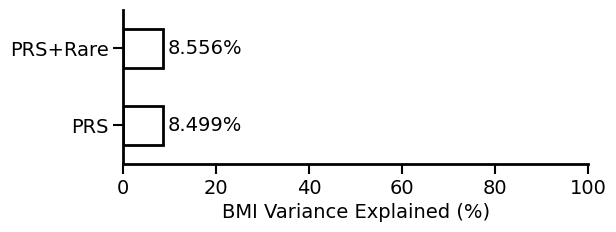

In [158]:
fig, axes = plt.subplots(1, 1, figsize=(6, 2))
axes.barh(
    plot_df["Model Variates"],
    plot_df["Variance explained"],
    height=0.5,
    edgecolor="k", linewidth=2,
    color="white"
    )
axes.set_xlim(0, 100)
axes.set_ylim(-0.5, 1.5)
axes.set_xlabel("BMI Variance Explained (%)")
axes.set_ylabel("")
axes.spines[['top', 'right']].set_visible(False)

rects =axes.patches
# Make some labels.
for rect in rects:
    width = rect.get_width()
    axes.text(
        width + 1, rect.get_y() + rect.get_height() / 2,  f"{round(width, 3)}%", ha="left", va="center"
    )